In [66]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import preprocess_input as nasnet_preprocess
from keras.applications.mobilenet_v2 import preprocess_input  as mobilenetv2_preprocess
from tensorflow.keras.applications import MobileNetV2, EfficientNetB6, NASNetLarge
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import numpy as np


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 25

BASE_DIR = '/kaggle/input/bean-leaf-dataset'

### Some Samples

Found 1034 images belonging to 3 classes.


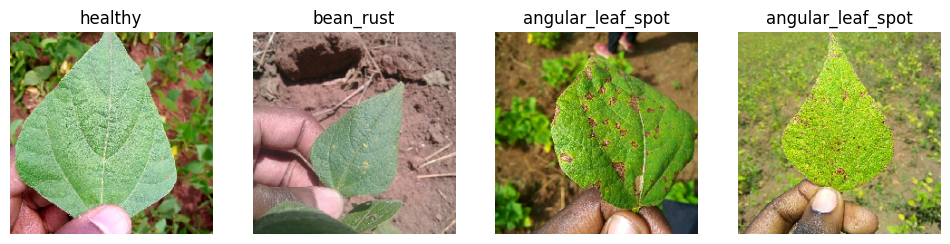

In [22]:
def show_sample_images(num_images=4):
    data_generator = ImageDataGenerator().flow_from_directory(
        directory=os.path.join(BASE_DIR, 'train', 'train'),
        target_size=(IMG_SIZE, IMG_SIZE)
    )
    images, labels = next(data_generator)

    class_indices = data_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    fig, axes = plt.subplots(1, num_images, figsize=(12, 5))
    for i in range(num_images):
        img = images[i]
        label_idx = labels[i].argmax()
        label = class_labels[label_idx]

        axes[i].imshow(img.astype("uint8"))
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.show()

show_sample_images()


### Augmentation

In [ ]:
augmentation = {
    'zoom_range':0.2,                      
    'horizontal_flip':True,        
    'vertical_flip':True,         
    'brightness_range':[0.8, 1.2]  
}

Found 1034 images belonging to 3 classes.
Found 1034 images belonging to 3 classes.


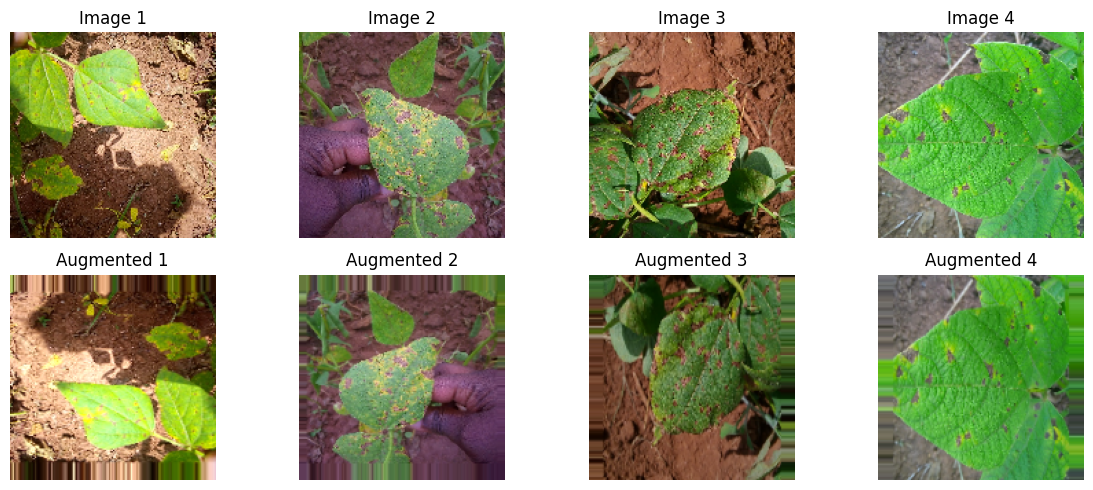

In [ ]:
simple = ImageDataGenerator(
    rescale=1.0 / 255
)

augmentated = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=augmentation['zoom_range'],
    horizontal_flip=augmentation['horizontal_flip'],
    vertical_flip=augmentation['vertical_flip'],
    brightness_range=augmentation['brightness_range']
)

sample_dir = os.path.join(BASE_DIR, 'train', 'train')

simple_generator = simple.flow_from_directory(
    directory=sample_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

augmentated_generator = augmentated.flow_from_directory(
    directory=sample_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

def plot_images(simple, augmentated, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 5))

    for i in range(num_images):
        original_image = next(simple)[0]
        augmented_image = next(augmentated)[0]

        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f"Image {i+1}")
        axes[0, i].axis("off")

        axes[1, i].imshow(augmented_image)
        axes[1, i].set_title(f"Augmented {i+1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(simple_generator, augmentated_generator, num_images=4)

### Model and Training

In [ ]:
def get_generators(model_name):
    preprocess = None
    if (model_name == "nasnetlarge"):
        preprocess = nasnet_preprocess
    train_datagen, test_val_generator = None, None
    if (model_name == "mobilenetv2"):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            zoom_range=augmentation['zoom_range'],                   
            horizontal_flip=augmentation['horizontal_flip'],          
            vertical_flip=augmentation['vertical_flip'],            
            brightness_range=augmentation['brightness_range']   
        )

        test_val_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess,             
            zoom_range=augmentation['zoom_range'],                       
            horizontal_flip=augmentation['horizontal_flip'],          
            vertical_flip=augmentation['vertical_flip'],            
            brightness_range=augmentation['brightness_range']  
        )

        test_val_datagen = ImageDataGenerator(preprocessing_function=preprocess)
        
    train_generator = train_datagen.flow_from_directory(
        directory=os.path.join(BASE_DIR, 'train', 'train'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = test_val_datagen.flow_from_directory(
        directory=os.path.join(BASE_DIR, 'validation', 'validation'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_val_datagen.flow_from_directory(
        directory=os.path.join(BASE_DIR, 'test', 'test'),
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator


In [50]:
class ModelHandler:
    def __init__(self, model_name, optimizer=None):
        self.model_name = model_name
        self.optimizer = optimizer
        self.img_size = 224
        self.batch_size = 32
        self.num_classes = 3
        self.epochs = 25
        self.model = self._create_model()
        self.train_generator, self.val_generator, self.test_generator = get_generators(self.model_name)

    def _create_model(self):
        if self.model_name == 'mobilenetv2':
            base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))
        elif self.model_name == 'efficientnet_b6':
            base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))
        elif self.model_name == 'nasnetlarge':
            base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(self.img_size, self.img_size, 3))
        else:
            raise ValueError(f"Model {self.model_name} is not supported.")
 
        base_model.trainable = False

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
#         x = Dense(256, activation='relu')(x)
        # x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        predictions = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)
        return model

    def train(self):
        self.model.compile(optimizer=self.optimizer,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        self.history = self.model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            epochs=self.epochs,
            verbose=1,
            callbacks=[early_stopping]
        )
        stopped_epoch = early_stopping.stopped_epoch
        if stopped_epoch > 0:
            print(f"Early stopping was triggered at epoch {stopped_epoch + 1}.")
        else:
            print("Training completed without triggering early stopping.")

    def evaluate(self):
        loss, accuracy = self.model.evaluate(self.test_generator, verbose=1)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")
        return loss, accuracy

    def plot_history(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(len(acc))

        plt.figure(figsize=(20, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title(f'Training and Validation Accuracy - {model_name} with {opt.name}')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title(f'Training and Validation Loss - {model_name} with {opt.name}')
        plt.show()
        
        return {'acc': acc, 'vall_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

    def predict(self, num_samples=5):
        val_batch = next(iter(self.val_generator))
        images, true_labels = val_batch

        predictions = self.model.predict(images)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(true_labels, axis=1)

        class_indices = {v: k for k, v in self.val_generator.class_indices.items()}

        plt.figure(figsize=(15, num_samples * 3))
        for i in range(min(num_samples, len(images))):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i])
            plt.axis("off")
            plt.title(
                f"True: {class_indices[true_labels[i]]}\nPred: {class_indices[predicted_labels[i]]}",
                color="green" if predicted_labels[i] == true_labels[i] else "red"
            )
        plt.tight_layout()
        plt.show()

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: mobilenetv2 - Optimizer: <keras.src.optimizers.adam.Adam object at 0x7800605a76a0>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 593ms/step - accuracy: 0.5606 - loss: 1.0060 - val_accuracy: 0.7820 - val_loss: 0.3866
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 442ms/step - accuracy: 0.7857 - loss: 0.5185 - val_accuracy: 0.8571 - val_loss: 0.3186
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 438ms/step - accuracy: 0.8166 - loss: 0.4781 - val_accuracy: 0.8722 - val_loss: 0.2725
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 435ms/step - accuracy: 0.8737 - loss: 0.3273 - val_accuracy: 0.9023 - val_loss: 0.2312
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.8768 - loss: 0.3028 - val_accuracy: 0.8797 - val_loss: 0.2887
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step - accuracy: 0.8817 - loss: 0.2854 - val_accuracy: 0.8947 - val_loss: 0.2875
Epo

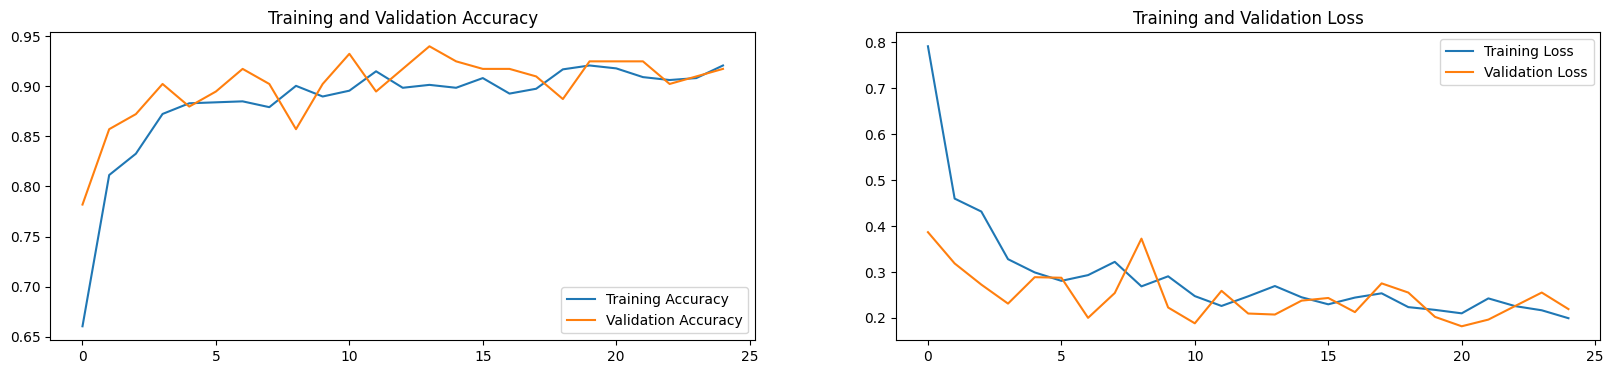

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: mobilenetv2 - Optimizer: <keras.src.optimizers.nadam.Nadam object at 0x78006a805ba0>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.5794 - loss: 0.9742 - val_accuracy: 0.8421 - val_loss: 0.3824
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step - accuracy: 0.8135 - loss: 0.4494 - val_accuracy: 0.8722 - val_loss: 0.3078
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 432ms/step - accuracy: 0.8460 - loss: 0.3732 - val_accuracy: 0.9098 - val_loss: 0.2468
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 444ms/step - accuracy: 0.8885 - loss: 0.3009 - val_accuracy: 0.8872 - val_loss: 0.3173
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - accuracy: 0.8741 - loss: 0.3100 - val_accuracy: 0.9023 - val_loss: 0.2393
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 430ms/step - accuracy: 0.8917 - loss: 0.2936 - val_accuracy: 0.8872 - val_loss: 0.2640
E

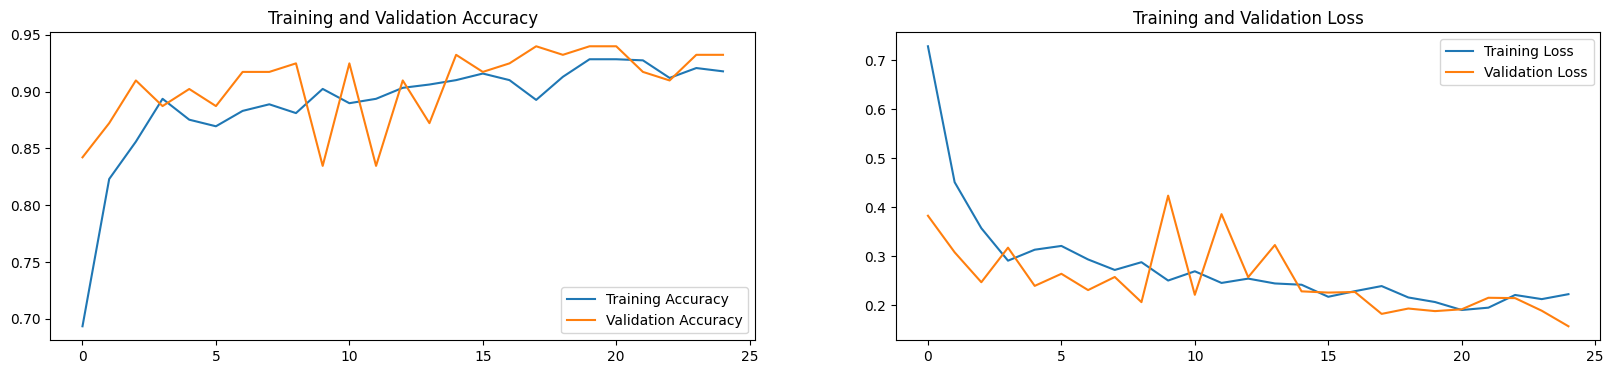

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: mobilenetv2 - Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x780061f341f0>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 589ms/step - accuracy: 0.5748 - loss: 1.2698 - val_accuracy: 0.7594 - val_loss: 0.5831
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 435ms/step - accuracy: 0.7748 - loss: 0.5402 - val_accuracy: 0.7970 - val_loss: 0.4617
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 431ms/step - accuracy: 0.8112 - loss: 0.4924 - val_accuracy: 0.8045 - val_loss: 0.4179
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.8016 - loss: 0.5016 - val_accuracy: 0.9098 - val_loss: 0.2646
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 434ms/step - accuracy: 0.8522 - loss: 0.3712 - val_accuracy: 0.8496 - val_loss: 0.4084
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step - accuracy: 0.8343 - loss: 0.4170 - val_accuracy: 0.8947 - val_loss: 0.24

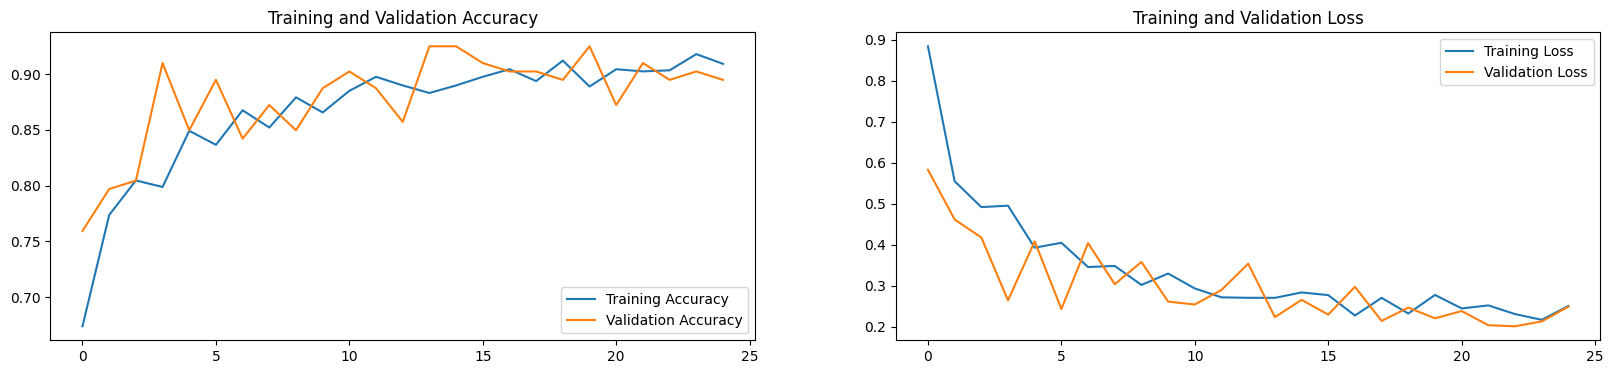

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: efficientnet_b6 - Optimizer: <keras.src.optimizers.adam.Adam object at 0x780061f36230>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.5547 - loss: 0.8991 - val_accuracy: 0.8120 - val_loss: 0.5366
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - accuracy: 0.8104 - loss: 0.4920 - val_accuracy: 0.8195 - val_loss: 0.4835
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 505ms/step - accuracy: 0.8125 - loss: 0.4462 - val_accuracy: 0.8346 - val_loss: 0.4230
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 476ms/step - accuracy: 0.8545 - loss: 0.3873 - val_accuracy: 0.8647 - val_loss: 0.3838
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 474ms/step - accuracy: 0.8519 - loss: 0.3861 - val_accuracy: 0.7970 - val_loss: 0.5061
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 508ms/step - accuracy: 0.8888 - loss: 0.3199 - val_accuracy: 0.8722 - val_loss: 0.3792
E

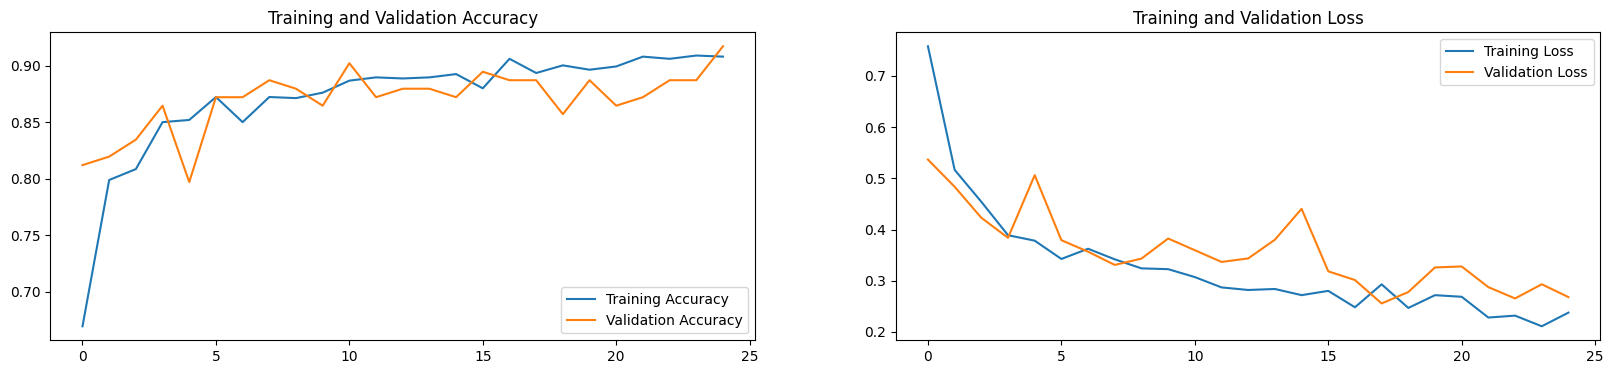

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: efficientnet_b6 - Optimizer: <keras.src.optimizers.nadam.Nadam object at 0x780061f35c90>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.6002 - loss: 0.8689 - val_accuracy: 0.8271 - val_loss: 0.4831
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - accuracy: 0.8009 - loss: 0.4896 - val_accuracy: 0.8421 - val_loss: 0.4400
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 487ms/step - accuracy: 0.8417 - loss: 0.3958 - val_accuracy: 0.8346 - val_loss: 0.4294
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 495ms/step - accuracy: 0.8491 - loss: 0.3883 - val_accuracy: 0.8722 - val_loss: 0.3627
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 476ms/step - accuracy: 0.8980 - loss: 0.2861 - val_accuracy: 0.8797 - val_loss: 0.3634
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 469ms/step - accuracy: 0.8889 - loss: 0.3202 - val_accuracy: 0.8120 - val_loss: 0.4271

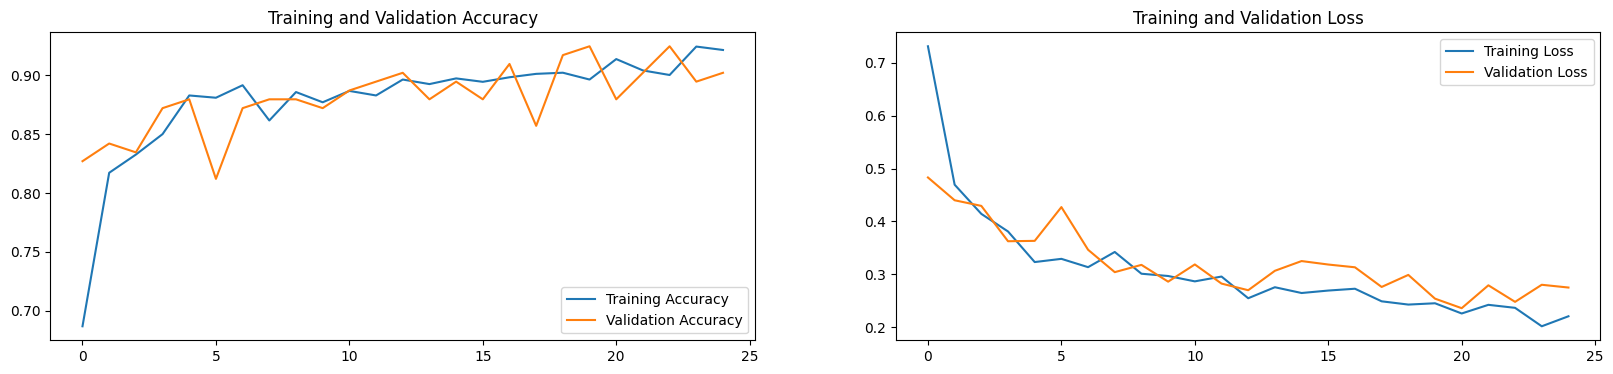

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: efficientnet_b6 - Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x7800605cfc10>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.5306 - loss: 0.9767 - val_accuracy: 0.8195 - val_loss: 0.5416
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.7922 - loss: 0.5288 - val_accuracy: 0.8120 - val_loss: 0.4351
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - accuracy: 0.7963 - loss: 0.4836 - val_accuracy: 0.8421 - val_loss: 0.4472
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - accuracy: 0.8243 - loss: 0.4468 - val_accuracy: 0.7895 - val_loss: 0.5001
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.8536 - loss: 0.3866 - val_accuracy: 0.8722 - val_loss: 0.3353
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 483ms/step - accuracy: 0.8350 - loss: 0.3785 - val_accuracy: 0.8571 - val_loss: 0.

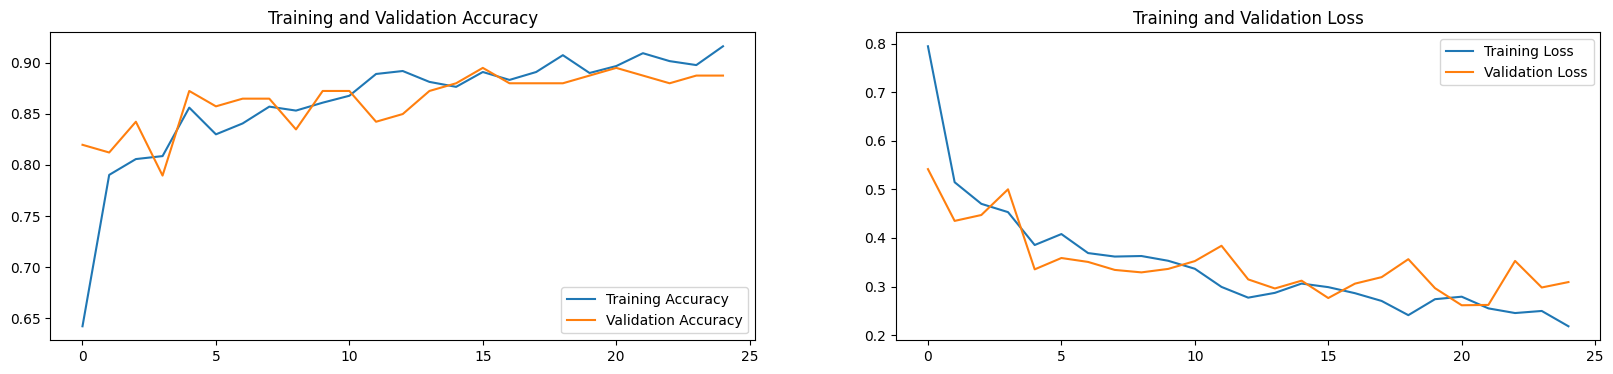

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: nasnetlarge - Optimizer: <keras.src.optimizers.adam.Adam object at 0x780061f35510>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5244 - loss: 1.1949 - val_accuracy: 0.8722 - val_loss: 0.4922
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 564ms/step - accuracy: 0.7435 - loss: 0.5644 - val_accuracy: 0.9023 - val_loss: 0.3414
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 543ms/step - accuracy: 0.7894 - loss: 0.4853 - val_accuracy: 0.8647 - val_loss: 0.3819
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 548ms/step - accuracy: 0.8027 - loss: 0.4712 - val_accuracy: 0.8271 - val_loss: 0.3590
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 558ms/step - accuracy: 0.8437 - loss: 0.3926 - val_accuracy: 0.8421 - val_loss: 0.3948
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 558ms/step - accuracy: 0.8233 - loss: 0.4312 - val_accuracy: 0.8872 - val_loss: 0.3079
Epoch

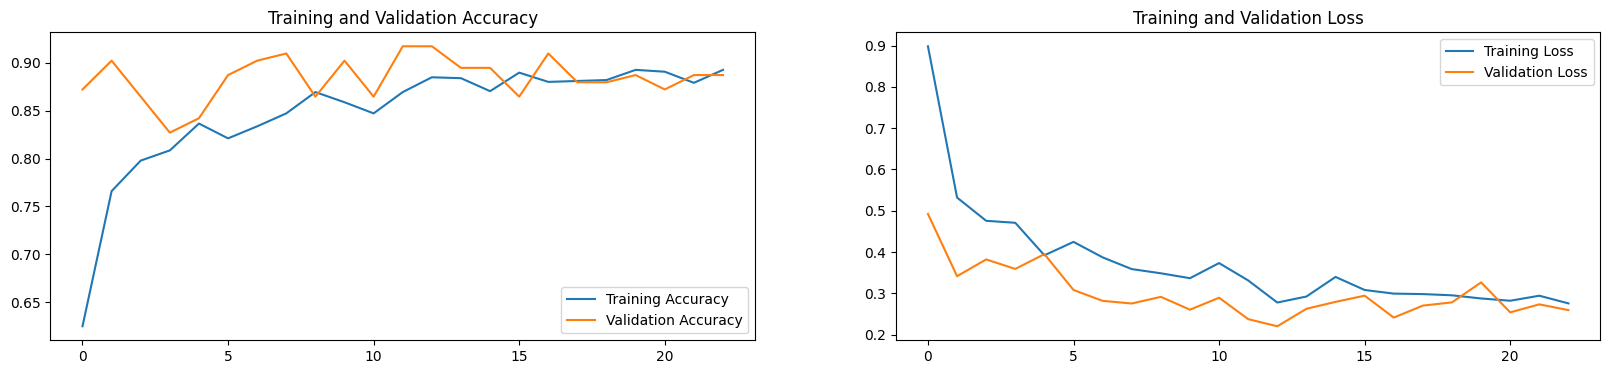

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: nasnetlarge - Optimizer: <keras.src.optimizers.nadam.Nadam object at 0x780061f34fa0>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5574 - loss: 0.9643 - val_accuracy: 0.8195 - val_loss: 0.4634
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - accuracy: 0.7742 - loss: 0.5176 - val_accuracy: 0.8722 - val_loss: 0.3343
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 550ms/step - accuracy: 0.8115 - loss: 0.4684 - val_accuracy: 0.8797 - val_loss: 0.3060
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 552ms/step - accuracy: 0.8028 - loss: 0.4205 - val_accuracy: 0.9248 - val_loss: 0.2580
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.8349 - loss: 0.3930 - val_accuracy: 0.8872 - val_loss: 0.3857
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step - accuracy: 0.8456 - loss: 0.3716 - val_accuracy: 0.8346 - val_loss: 0.3301
Epoc

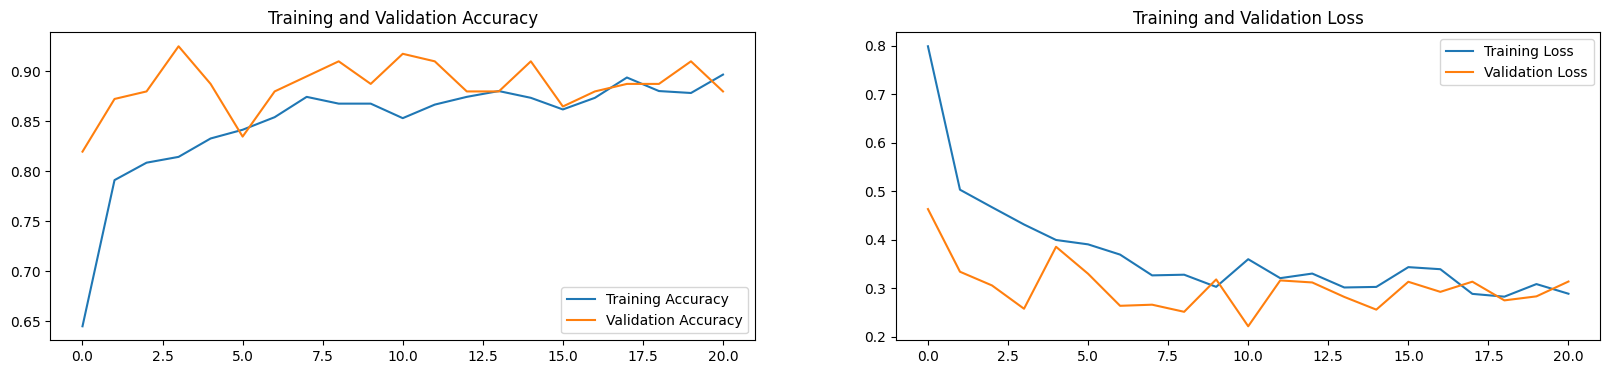

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Training model: nasnetlarge - Optimizer: <keras.src.optimizers.rmsprop.RMSprop object at 0x780061f34a30>
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.4960 - loss: 1.6391 - val_accuracy: 0.8120 - val_loss: 0.5504
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 578ms/step - accuracy: 0.7169 - loss: 0.6516 - val_accuracy: 0.8421 - val_loss: 0.4867
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 560ms/step - accuracy: 0.7540 - loss: 0.5653 - val_accuracy: 0.8195 - val_loss: 0.5348
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step - accuracy: 0.7773 - loss: 0.5425 - val_accuracy: 0.8797 - val_loss: 0.3200
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 537ms/step - accuracy: 0.8104 - loss: 0.4941 - val_accuracy: 0.8722 - val_loss: 0.3445
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 557ms/step - accuracy: 0.8513 - loss: 0.4044 - val_accuracy: 0.8496 - val_loss: 0.3716


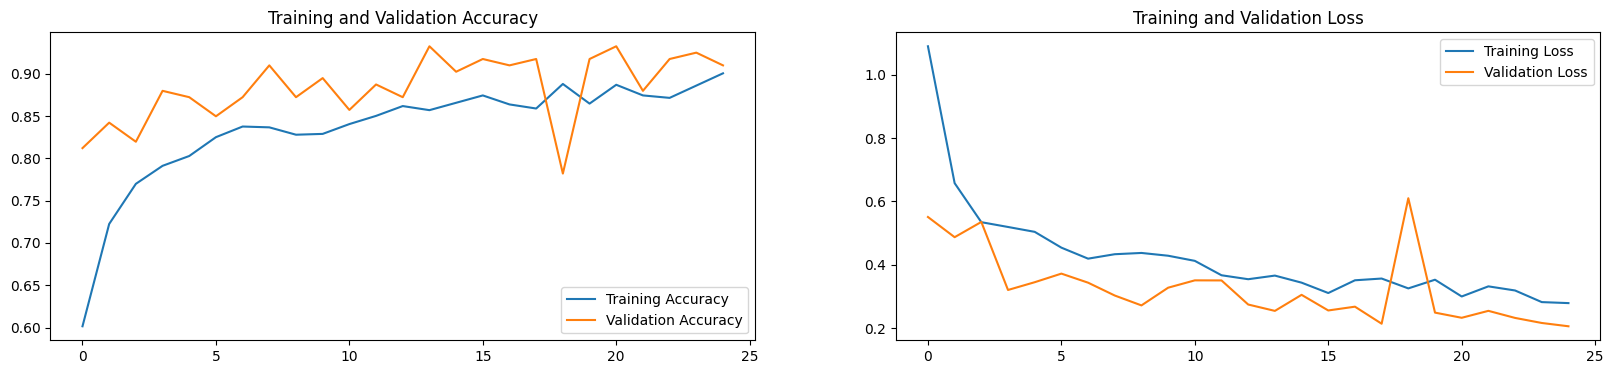

In [48]:
model_names = {
                'mobilenetv2': [Adam(learning_rate=0.001), Nadam(learning_rate=0.001), RMSprop(learning_rate=0.001)],
                'efficientnet_b6': [Adam(learning_rate=0.001), Nadam(learning_rate=0.001), RMSprop(learning_rate=0.001)],
                'nasnetlarge': [Adam(learning_rate=0.001), Nadam(learning_rate=0.001), RMSprop(learning_rate=0.001)]
              }
hist = []
if __name__ == "__main__":
    for model_name, opts in model_names.items():
        for opt in opts:
            model = ModelHandler(model_name=model_name, optimizer=opt)
            
            print(f"Training model: {model_name} - Optimizer: {opt}")
            model.train()

            print("Evaluating model on the test set...")
            model.evaluate()

            hist.append(model.plot_history())

---

### Prediction

In [52]:
model = ModelHandler(model_name='mobilenetv2', optimizer=Nadam(learning_rate=0.001))
model.train()


Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.6011 - loss: 0.9012 - val_accuracy: 0.8496 - val_loss: 0.3652
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - accuracy: 0.8411 - loss: 0.3901 - val_accuracy: 0.9023 - val_loss: 0.2802
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8843 - loss: 0.3237 - val_accuracy: 0.9173 - val_loss: 0.2584
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.8732 - loss: 0.3000 - val_accuracy: 0.8947 - val_loss: 0.2632
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 360ms/step - accuracy: 0.8675 - loss: 0.2933 - val_accuracy: 0.9098 - val_loss: 0.2325
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - accuracy: 0.9061 - loss: 0.2536 - val_accuracy: 0.9023 - val_loss: 0.2603
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - accuracy: 0.9050 - loss: 0.2202 - val_accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


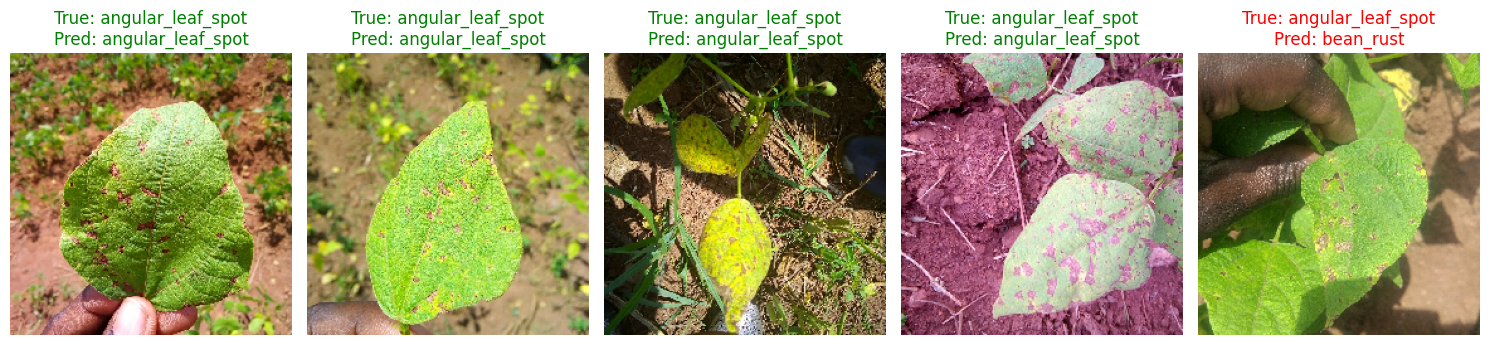

In [53]:
model.predict(5)

Found 1034 images belonging to 3 classes.
Found 133 images belonging to 3 classes.
Found 128 images belonging to 3 classes.
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


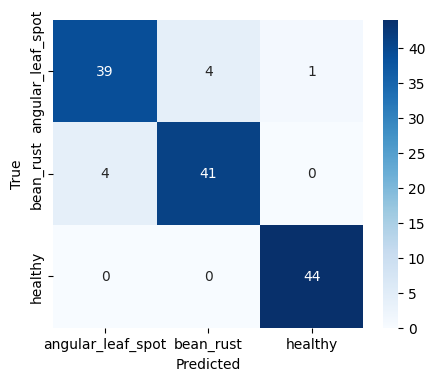

Confusion Matrix:
[[39  4  1]
 [ 4 41  0]
 [ 0  0 44]]


In [88]:
def plot_confusion_matrix(model, generator):
    preds = model.predict(generator)
    preds_classes = np.argmax(preds, axis=1)
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    cm = confusion_matrix(true_classes, preds_classes)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    # plt.title('Confusion Matrix for Validation Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("Confusion Matrix:")
    print(cm)

plot_confusion_matrix(model.model, get_generators('mobilenetv2')[1])